In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import batman
from ldtk import SVOFilter, LDPSetCreator
from matplotlib import gridspec
%matplotlib widget

In [26]:
taste_target_dictionary = pickle.load(open('../Results/TASTE/target_dictionary.p', 'rb'))
taste_bjd = taste_target_dictionary['time']
differential_allref = pickle.load(open('../Results/TASTE/differential_allref.p', 'rb'))
normalized_differential_allref_err = pickle.load(open('../Results/TASTE/differential_allref_err.p', 'rb'))
normalized_differential_allref = pickle.load(open('../Results/TASTE/normalized_diff_allref.p', 'rb'))

tess_sector76_dictionary = pickle.load(open('../Results/TESS/sector76_flatten.p', 'rb'))
tess_bjd = tess_sector76_dictionary['time']
tess_normalized_flux_76 = tess_sector76_dictionary['flux']
tess_normalized_flux_err_76 = tess_sector76_dictionary['flux_error']

In [27]:
sloan_r = SVOFilter('sdss_r')
tess_filter = SVOFilter('tess')

In [28]:
filter = [sloan_r, tess_filter]
sc = LDPSetCreator(teff=(4650, 60), logg=(4.61, 0.01), z=(-0.29, 0.05), filters=filter)
#it's gonna model the spectra for those parameters and convolve it with the filter
ps = sc.create_profiles(nsamples=2000)
ps.resample_linear_z(100)

ps.set_uncertainty_multiplier(10)
qm, qe = ps.coeffs_qd(do_mc=True, n_mc_samples=10000)
chains = np.array(ps._samples['qd'])

TESS LD coeff u1 = 0.5011 \pm 0.0078
Sloan r LD coeff u1 = 0.637 \pm 0.012


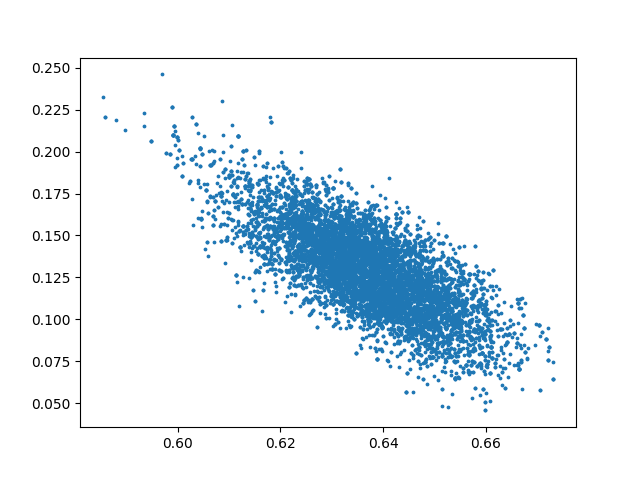

In [29]:
u1_sloan_r_chains = chains[0, :, 0]
u2_sloan_r_chains = chains[0, :, 1]

u1_tess_chains = chains[1, :, 0]
u2_tess_chains = chains[1, :, 1]

print(f'TESS LD coeff u1 = {np.median(u1_tess_chains):.4f} \pm {np.std(u1_tess_chains):.4f}')
print(f'Sloan r LD coeff u1 = {np.median(u1_sloan_r_chains):.3f} \pm {np.std(u1_sloan_r_chains):.3f}')

plt.figure()
plt.scatter(u1_sloan_r_chains, u2_sloan_r_chains, s=3)
plt.show()

In [30]:
print(f'{np.median(u1_tess_chains):.4f}', '\pm', f'{np.std(u1_tess_chains):.4f}')
print(f'{np.median(u2_tess_chains):.4f}', '\pm', f'{np.std(u2_tess_chains):.4f}')
print()
print(f'{np.median(u1_sloan_r_chains):.4f}', '\pm', f'{np.std(u1_sloan_r_chains):.4f}')
print(f'{np.median(u2_sloan_r_chains):.4f}', '\pm', f'{np.std(u2_sloan_r_chains):.4f}')


0.5011 \pm 0.0078
0.1396 \pm 0.0199

0.6367 \pm 0.0124
0.1300 \pm 0.0258


In [8]:
transit_time = 2459685.398095
period = 3.2130578
transit_duration = 2.169 / 24.

phase_folded_time = (tess_bjd - transit_time - period/2)%period - period/2

taste_bjd = taste_bjd - 2459990.6385861     #from MCMC

In [29]:
#overimpose the model with the TASTE and TESS normalized light curves

params_taste = batman.TransitParams()       #object to store transit parameters
params_taste.t0 = 0.0             #time of inferior conjunction
params_taste.per = 3.21305762                    #orbital period
params_taste.rp = 0.1406                     #planet radius (in units of stellar radii)
params_taste.a = 11.77                     #semi-major axis (in units of stellar radii)
params_taste.inc = 89                    #orbital inclination (in degrees)
params_taste.ecc = 0.                       #eccentricity
params_taste.w = 90.                      #longitude of periastron (in degrees)
params_taste.limb_dark = "quadratic"        #limb darkening model
params_taste.u = [np.median(u1_sloan_r_chains), np.median(u2_sloan_r_chains)]                 #limb darkening coefficients [u1, u2, u3, u4]

m = batman.TransitModel(params_taste, taste_bjd)    #initializes model

flux_taste = m.light_curve(params_taste)

########################################################################################################

params_tess = batman.TransitParams()       #object to store transit parameters
params_tess.t0 = 0.0            #time of inferior conjunction
params_tess.per = 3.2130578                    #orbital period
params_tess.rp = 0.1406                     #planet radius (in units of stellar radii)
params_tess.a = 11.77                     #semi-major axis (in units of stellar radii)
params_tess.inc = 89.0                    #orbital inclination (in degrees)
params_tess.ecc = 0.                       #eccentricity
params_tess.w = 90.                     #longitude of periastron (in degrees)
params_tess.limb_dark = "quadratic"        #limb darkening model
params_tess.u = [np.median(u1_tess_chains), np.median(u2_tess_chains)]                 #limb darkening coefficients [u1, u2]

folded_tess_time = (tess_bjd - 2459685.398095 - params_tess.per/2. ) % params_tess.per - params_tess.per/2. 
folded_range = np.linspace(- params_tess.per/2.,  params_tess.per/2., 9257)

m = batman.TransitModel(params_tess, folded_range)    #initializes model

flux_tess = m.light_curve(params_tess)

params_tess.t0 = 2459685.398095
m = batman.TransitModel(params_tess, tess_bjd)
flux_tess_res = m.light_curve(params_tess)

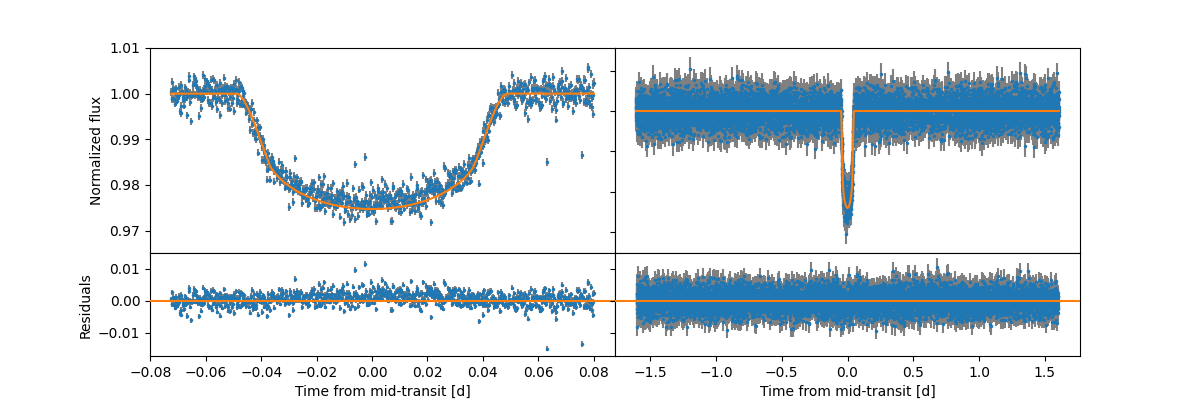

In [36]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])

ax0 = plt.subplot(gs[0])
ax0.errorbar(taste_bjd, normalized_differential_allref, yerr=normalized_differential_allref_err, ecolor='gray', fmt='.', markersize=3)
ax0.plot(taste_bjd, flux_taste, c='C1', zorder=3)
plt.setp(ax0.get_xticklabels(), visible=False)
ax0.set_ylim(0.965, 1.01)
ax0.set_ylabel('Normalized flux')

ax1 = plt.subplot(gs[1])
ax1.errorbar(folded_tess_time, tess_normalized_flux_76, yerr=tess_normalized_flux_err_76, ecolor='gray', fmt='.', markersize=3)
ax1.plot(folded_range, flux_tess, c='C1', zorder=3)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax1.get_yticklabels(), visible=False)

ax2 = plt.subplot(gs[2], sharex=ax0)
ax2.errorbar(taste_bjd, normalized_differential_allref - flux_taste, yerr=normalized_differential_allref_err, ecolor='gray', fmt='.', markersize=3)
ax2.axhline(0, c='C1', zorder=3)
ax2.set_ylabel('Residuals')
ax2.set_xlabel('Time from mid-transit [d]')

residuals_tess = np.linspace(-1.6, 1.6, 9257)
ax3 = plt.subplot(gs[3], sharey=ax2, sharex=ax1)
ax3.errorbar(residuals_tess, tess_normalized_flux_76 - flux_tess_res, yerr=tess_normalized_flux_err_76, ecolor='gray', fmt='.', markersize=3)
ax3.axhline(0, c='C1', zorder=3)
ax3.set_xlabel('Time from mid-transit [d]')
plt.setp(ax3.get_yticklabels(), visible=False)

plt.subplots_adjust(hspace=.0, wspace=.0)
plt.savefig('./Plots/residuals.png', dpi = 1000)

plt.show()